In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings('ignore')

from util import Util
from data_cleaner import DataCleaner
from model import Model
from preprocessor import Preprocessor
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

In [2]:
util = Util()
cleaner = DataCleaner()
processor = Preprocessor()

In [3]:
# read our merged train and test dataset

repo="https://github.com/Nathnael12/pharmaceutical-sales-pridiction.git"
# repo="../"

# feature_engineered_train=util.read_from_dvc("data/featured_train.csv",repo,"featured-v0",low_memory=False)

# read from local file since dvc is taking too much time
feature_engineered_train=util.read_from_file("../data/featured_train.csv") 

In [5]:
feature_engineered_train["Date"]= pd.DatetimeIndex(feature_engineered_train["Day"].astype(str)+'-' + feature_engineered_train["Month"].astype(str)+'-' + feature_engineered_train["Year"].astype(str))
feature_engineered_train.set_index('Date',inplace=True)

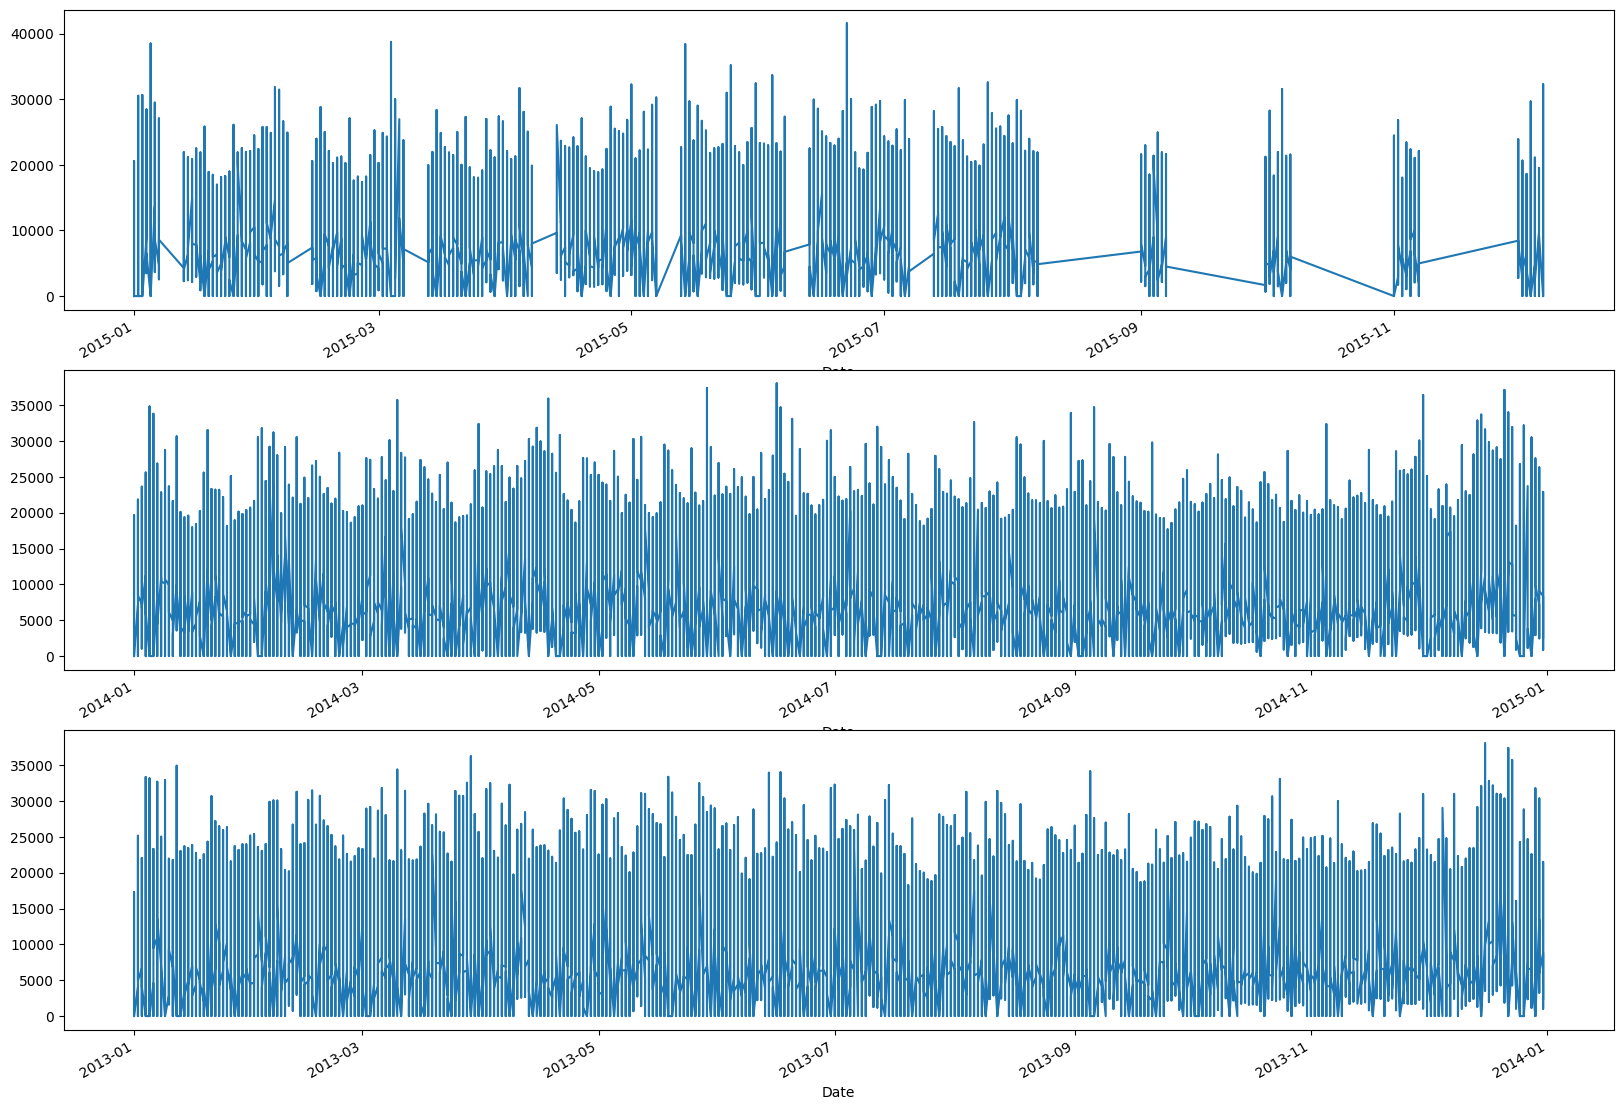

In [6]:
plt.subplots(3,1,figsize=(20,15))
plt.subplot(3,1,1)
feature_engineered_train.loc['2015']['Sales'].plot()
plt.subplot(3,1,2)
feature_engineered_train.loc['2014']['Sales'].plot()
plt.subplot(3,1,3)
feature_engineered_train.loc['2013']['Sales'].plot()
plt.show()

as seen from the above plot we havea stationary time series data (the way our data changes is uniform over time)

In [7]:
feature_engineered_train=feature_engineered_train.sort_index()

In [9]:
ny_df_final=feature_engineered_train.reset_index()[['Date','Sales']].rename({'Date':'ds','Sales':'y'}, axis='columns')

In [10]:
# y=feature_engineered_train['Sales']
# X=feature_engineered_train.drop('Sales',axis=1)

input_data=(ny_df_final,feature_engineered_train['Sales'])
size=(.8,.2)
final_80, train_y, final_20, test_y = util.train_test_split(input_data,size)

In [16]:
sales_corr=feature_engineered_train.copy()
# sales_corr["Date"]=pd.DatetimeIndex(feature_engineered_train["Day"].astype(str)+'-' + feature_engineered_train["Month"].astype(str)+'-' + feature_engineered_train["Year"].astype(str))


In [18]:
sales_lag=feature_engineered_train.groupby('Store').agg({"Sales":"sum"})

sales_corr = sales_corr.groupby('Date').agg({"Sales":"sum"})

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

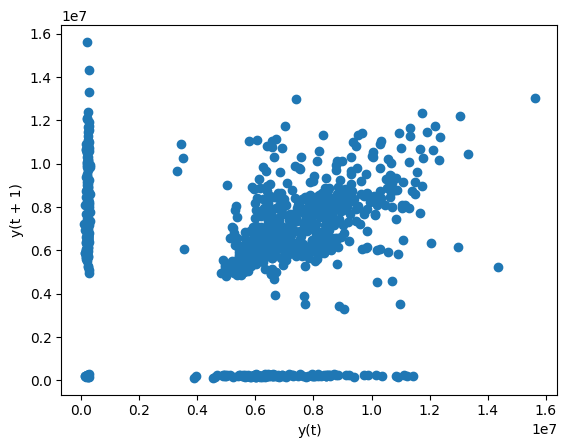

In [19]:
pd.plotting.lag_plot(sales_corr['Sales'],lag=1)
# pd.plotting.lag_plot(feature_engineered_train['Sales'],lag=8760)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

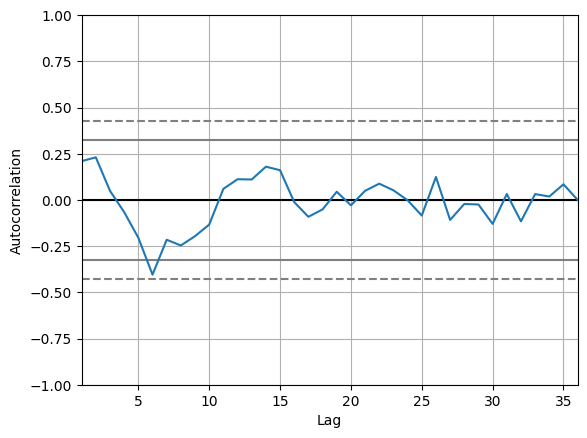

In [20]:

pd.plotting.autocorrelation_plot(sales_corr['Sales'].resample("1m").mean())

Based on the above plots we can see that their is  a small relationship (linear) between daily data points 

In [21]:
# Let's turn them into numpy arrays
X_train, y_train = np.array(train_x), np.array(train_y)
print("X_train data shape:", X_train.shape)
print("y_train data shape:", y_train.shape)

X_test, y_test = np.array(test_x), np.array(test_y)
print("X_test data shape:", X_test.shape)
print("y_test data shape:", y_test.shape)

NameError: name 'train_x' is not defined

In [ ]:
from fbprophet import Prophet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard